In [1]:
%config Completer.use_jedi = False

In [2]:
# Read in data with an optional subset to shorten testing time
# If reshape=True, return 2d array values
def load_dataset(filename, cramer_coef, target, var_count, row_count, reshape=False):
    df = pd.read_csv(filename, index_col=0, header=0, nrows=row_count)
    
    # split into input (X) and output (y) variables
    X = df.drop(target, axis=1, inplace=False)
    
    # order columns by Cramer coeffs
    cramer_df = pd.read_csv(cramer_coef, sep='\t', header=None)
    cols = cramer_df.iloc[:, 0].tolist()
    X = X[cols]
    y = df[target]
    
    # Reduce # of variables
    if var_count < X.shape[1]:
        X = X.iloc[:, 0:var_count]
        
    # reshape target to be a 2d array, if flag set
    if reshape:
        y = df[target].values
        y = y.reshape((len(y), 1))
        X = X.values

    return X, y 

In [3]:
%%time
# evaluate weighted svm with calibrated probabilities for imbalanced classification
import pandas as pd
from numpy import mean
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# load dataset
#X, y = load_dataset('/MFMDatasets/MFM_bopf/data/csl/CSL_tl_PI.csv', 
#                    '/MFMDatasets/MFM_bopf/data/csl/CramerTheil/Cramer_PI_Tl_coeff_Union50.csv', 
#                    'trans_loss', 66, 200000, reshape=False)
X, y = load_dataset('/MFMDatasets/MFM_bopf/data/csl/CSL_tl_PI.csv', 
                    '/MFMDatasets/MFM_bopf/data/csl/CramerTheil/Cramer_PI_Tl_coeff_ALL.csv', 
                    'trans_loss', 200, 200000, reshape=False)
print(f'X.shape = {X.shape}; y.shape = {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30)
print(f'X_train.shape = {X_train.shape}; y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}; y_test.shape = {y_test.shape}')

# define model
model = RandomForestClassifier(n_estimators=128, max_leaf_nodes=100, max_depth=40, min_samples_leaf=1, min_samples_split=16, class_weight='balanced', random_state=7)
# NOTE: simple change to max_leaf_nodes destroys prediction to Recall of 0.16 (from 0.90)
#model = RandomForestClassifier(n_estimators=128, max_leaf_nodes=None, max_depth=40, min_samples_leaf=1, min_samples_split=16, class_weight='balanced', random_state=7)
model.fit(X_train, y_train)
print(f'model.get_params(): {model.get_params()}')
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)
prob1 = probs[:,1]

X.shape = (185413, 192); y.shape = (185413,)
X_train.shape = (129789, 192); y_train.shape = (129789,)
X_test.shape = (55624, 192); y_test.shape = (55624,)
model.get_params(): {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 40, 'max_features': 'auto', 'max_leaf_nodes': 100, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 16, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 128, 'n_jobs': None, 'oob_score': False, 'random_state': 7, 'verbose': 0, 'warm_start': False}
CPU times: user 23.4 s, sys: 1.53 s, total: 25 s
Wall time: 25 s


In [4]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, auc, roc_auc_score, precision_score
from imblearn.metrics import geometric_mean_score, sensitivity_specificity_support
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
roc_auc_s_prob = roc_auc_score(y_test, prob1)
print(f'ROC_AUC = {roc_auc_s_prob}')
#pr_auc = auc(recall, precision)
#print(f' PR_AUC = {pr_auc}')
#prec = precision_score(y_test, y_pred, pos_label=2)
prec = precision_score(y_test, y_pred)
print(f'   PREC = {prec}')
mcc = matthews_corrcoef(y_test, y_pred)
print(f'    MCC = {mcc}')
# Note: pos_label does not appear to have any effect
gmean_none = geometric_mean_score(y_test, y_pred, average=None)
print(f'gmean_none    = {gmean_none}')
gmean_macro = geometric_mean_score(y_test, y_pred, average='macro')
print(f'gmean_macro   = {gmean_macro}')
sens, spec, ss_supp = sensitivity_specificity_support(y_test, y_pred, average=None)
print(f'sens   = {sens}')
print(f'spec   = {spec}')

[[33244 19277]
 [  325  2778]]
              precision    recall  f1-score   support

           0       0.99      0.63      0.77     52521
           1       0.13      0.90      0.22      3103

    accuracy                           0.65     55624
   macro avg       0.56      0.76      0.50     55624
weighted avg       0.94      0.65      0.74     55624

ROC_AUC = 0.8235840510257846
   PREC = 0.12595783269099978
    MCC = 0.24783148878979297
gmean_none    = [0.75277533 0.75277533]
gmean_macro   = 0.7641142551619224
sens   = [0.63296586 0.89526265]
spec   = [0.89526265 0.63296586]


In [5]:
X_train['DMControl'].value_counts()

8    70238
7    56679
3     1497
1     1043
2      212
4      120
Name: DMControl, dtype: int64

In [6]:
import shap

In [7]:
explainer = shap.TreeExplainer(model)

In [8]:
%%time
shap_values = explainer.shap_values(X_train)

CPU times: user 14min 44s, sys: 2.94 s, total: 14min 47s
Wall time: 14min 43s


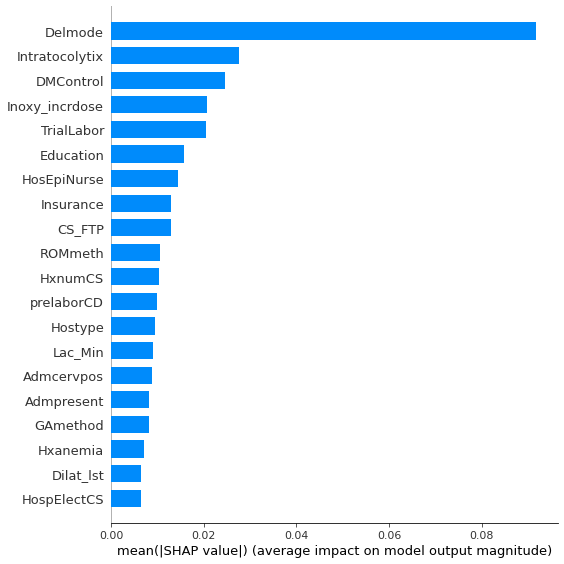

In [9]:
shap.summary_plot(shap_values[1], X_train, plot_type="bar", max_display=20)

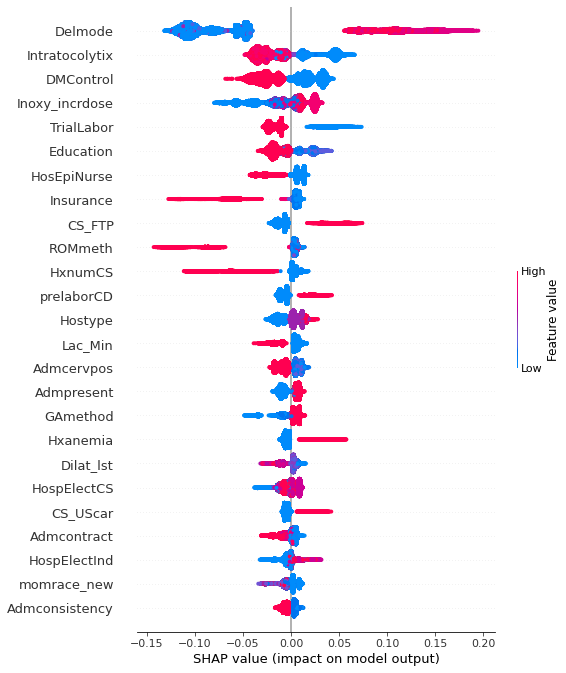

CPU times: user 19.1 s, sys: 250 ms, total: 19.4 s
Wall time: 19.3 s


In [10]:
%%time
shap.summary_plot(shap_values[1], X_train, max_display=25)

# NOTE: Following cells fail with errors due to a mismatch between latest SHAP and Matplotlib v. 3.5. 

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values[1], X_train, x_jitter=0.5, interaction_index='Delmode')

In [ ]:
shap.dependence_plot("Inoxy_incrdose", shap_values[1], X_train, x_jitter=0.5, interaction_index='Intratocolytix')

In [ ]:
shap.dependence_plot("HosEpiNurse", shap_values[1], X_train, x_jitter=0.2)

In [ ]:
shap.dependence_plot("DMControl", shap_values[1], X_train, interaction_index='Intratocolytix', x_jitter=0.2)

In [ ]:
shap.dependence_plot("high_Age", shap_values[1], X_train, interaction_index='Intratocolytix', x_jitter=0.2)

In [ ]:
shap.dependence_plot("high_Age", shap_values[1], X_train, x_jitter=0.2)